In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import surfa as sf 


In [9]:
lh_pial_file = '/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.pial'
lh_pial_H_file = '/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.pial.H'

lh_pial_mesh = sf.load_mesh(lh_pial_file)
lh_pial_H_mesh = sf.load_overlay(lh_pial_H_file)
lh_pial_H = lh_pial_H_mesh.data

In [10]:
bottom_of_sulci = lh_pial_H > np.percentile(lh_pial_H[lh_pial_H > 0], 90).astype(float)
top_of_gyri = (lh_pial_H < np.percentile(lh_pial_H[lh_pial_H < 0], 9›0)).astype(float)

In [11]:
import surfa as sf
import numpy as np

# Load mesh and curvature overlay
lh_pial_mesh = sf.load_mesh(lh_pial_file)
lh_pial_H_overlay = sf.load_overlay(lh_pial_H_file)
lh_pial_H = lh_pial_H_overlay.data

# Check just sign first (no percentile yet)
top_of_gyri = np.zeros_like(lh_pial_H, dtype=np.float32)
bottom_of_sulci = np.zeros_like(lh_pial_H, dtype=np.float32)

top_of_gyri[lh_pial_H > 0] = 1.0
bottom_of_sulci[lh_pial_H < 0] = 1.0

# Create overlay objects
top_overlay = sf.Overlay(top_of_gyri)
bottom_overlay = sf.Overlay(bottom_of_sulci)

# Assign geometry to overlays
top_overlay.geom = lh_pial_mesh.geom
bottom_overlay.geom = lh_pial_mesh.geom



In [12]:
import nibabel.freesurfer.io as fsio

# Ensure your data is float32 and matches number of vertices
top_of_gyri = top_of_gyri.astype(np.float32)
bottom_of_sulci = bottom_of_sulci.astype(np.float32)

# Write .curv files
fsio.write_morph_data('lh.top_of_gyri.curv', top_of_gyri)
fsio.write_morph_data('lh.bottom_of_sulci.curv', bottom_of_sulci)


In [43]:
import numpy as np
from nibabel.freesurfer.io import write_morph_data

# These must be 1D float32 arrays with the same number of elements as the surface vertices
top_of_gyri = top_of_gyri.astype(np.float32).flatten()
bottom_of_sulci = bottom_of_sulci.astype(np.float32).flatten()

# Optional: sanity check
print("Vertices in mesh:", lh_pial_mesh.vertices.shape[0])
print("Overlay length:", len(top_of_gyri))  # should match vertex count

# Save overlay data as FreeSurfer morph files (.curv format)
write_morph_data('lh.top_of_gyri.curv', top_of_gyri)
write_morph_data('lh.bottom_of_sulci.curv', bottom_of_sulci)


Vertices in mesh: 147259
Overlay length: 147259


In [52]:
import numpy as np
import surfa as sf

# Load surface mesh and curvature
mesh = sf.load_mesh("/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.pial")
H = sf.load_overlay("/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.curv").data

# Threshold: top 5% of positive curvature values
positive_H = H[H > 0]
thresh = np.percentile(positive_H, 95)
gyri_top_mask = (H >= thresh)

# Get the 3D coordinates of the top gyri vertices
gyri_top_coords = mesh.vertices[gyri_top_mask]


from scipy.interpolate import splprep, splev
from sklearn.decomposition import PCA

# Optional: project points to 2D plane for easier spline fitting
pca = PCA(n_components=2)
points_2d = pca.fit_transform(gyri_top_coords)

# Fit spline in 2D
tck, u = splprep(points_2d.T, s=5.0)
u_fine = np.linspace(0, 1, 500)
spline_2d = splev(u_fine, tck)

# Transform back to 3D
spline_3d = pca.inverse_transform(np.vstack(spline_2d).T)


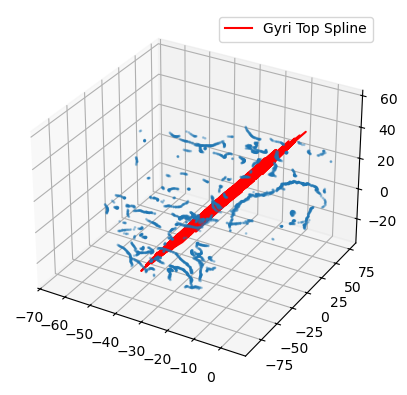

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*spline_3d.T, color='red', label='Gyri Top Spline')
ax.scatter(*gyri_top_coords.T, alpha=0.3, s=1)
ax.legend()
plt.show()


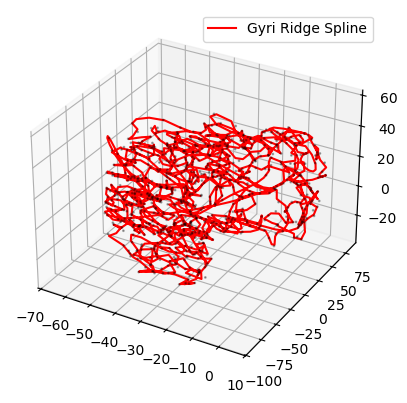

In [58]:
import surfa as sf
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# Load surface and curvature
mesh = sf.load_mesh("/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.pial")
H = sf.load_overlay("/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.curv").data
faces = mesh.faces

# Create adjacency list
adj_list = [[] for _ in range(len(H))]
for face in faces:
    for i in range(3):
        adj_list[face[i]].extend([face[(i+1)%3], face[(i+2)%3]])
adj_list = [list(set(neigh)) for neigh in adj_list]

# Find local maxima in positive curvature
ridge_indices = []
for i, neighbors in enumerate(adj_list):
    if H[i] <= 0:
        continue
    if all(H[i] > H[n] for n in neighbors):
        ridge_indices.append(i)

ridge_coords = mesh.vertices[ridge_indices]

from scipy.interpolate import splprep, splev
from scipy.spatial import cKDTree

# Basic greedy nearest-neighbor ordering
tree = cKDTree(ridge_coords)
ordered = [0]
used = set(ordered)
for _ in range(len(ridge_coords) - 1):
    dists, idxs = tree.query(ridge_coords[ordered[-1]], k=len(ridge_coords))
    next_idx = next(i for i in idxs if i not in used)
    ordered.append(next_idx)
    used.add(next_idx)

ordered_coords = ridge_coords[ordered]
x, y, z = ordered_coords.T
tck, _ = splprep([x, y, z], s=2)
u = np.linspace(0, 1, 1000)
xs, ys, zs = splev(u, tck)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs, color='red', label='Gyri Ridge Spline')
ax.scatter(*ridge_coords.T, color='k', s=1, alpha=0.3)
plt.legend()
plt.show()


In [10]:
import numpy as np
import networkx as nx
import surfa as sf
import time

# === Load surface and curvature ===
mesh = sf.load_mesh("/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.pial")
H = sf.load_overlay("/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs/388_21yrOld_edited/surf/lh.curv").data             # Or 'lh.curv' if H isn't available

# === Build adjacency list for local maxima detection ===
adj_list = [[] for _ in range(len(mesh.vertices))]
for face in mesh.faces:
    for i in range(3):
        a, b = face[i], face[(i + 1) % 3]
        adj_list[a].append(b)
        adj_list[b].append(a)
adj_list = [list(set(n)) for n in adj_list]

# === Step 1: Find local curvature maxima (gyri peaks) ===
ridge_indices = []
for i, neighbors in enumerate(adj_list):
    if H[i] <= 0:
        continue
    if all(H[i] > H[n] for n in neighbors):
        ridge_indices.append(i)

print(f"Found {len(ridge_indices)} gyri peak candidates.")

# === Step 2: Build surface graph ===
G = nx.Graph()
for face in mesh.faces:
    for i in range(3):
        a, b = face[i], face[(i + 1) % 3]
        dist = np.linalg.norm(mesh.vertices[a] - mesh.vertices[b])
        G.add_edge(a, b, weight=dist)

# === Step 3: Trace geodesic paths from sampled ridge vertices ===
density = np.zeros(len(mesh.vertices), dtype=np.float32)
sampled_ridges = ridge_indices[::2]  # adjust stride for speed/coverage

start_time = time.time()
for i, seed in enumerate(sampled_ridges):
    try:
        lengths, paths = nx.single_source_dijkstra(G, seed, weight='weight', cutoff=50)  # cutoff for speed
        for path in paths.values():
            for v in path:
                density[v] += 1
    except:
        continue
print(f"Completed in {time.time() - start_time:.2f} seconds")

# === Step 4: Normalize and enhance contrast ===
density = np.log1p(density)
if density.max() > 0:
    density /= density.max()

# === Step 5: Save as VTK for visualization ===
def write_vtk_surface_with_scalar(vertices, faces, scalars, output_path):
    with open(output_path, 'w') as f:
        f.write('# vtk DataFile Version 3.0\n')
        f.write('Geodesic Path Density Map\n')
        f.write('ASCII\n')
        f.write('DATASET POLYDATA\n')
        f.write(f'POINTS {len(vertices)} float\n')
        for v in vertices:
            f.write(f'{v[0]} {v[1]} {v[2]}\n')
        f.write(f'POLYGONS {len(faces)} {len(faces) * 4}\n')
        for tri in faces:
            f.write(f'3 {tri[0]} {tri[1]} {tri[2]}\n')
        f.write(f'POINT_DATA {len(scalars)}\n')
        f.write('SCALARS density float 1\n')
        f.write('LOOKUP_TABLE default\n')
        for val in scalars:
            f.write(f'{val:.6f}\n')

write_vtk_surface_with_scalar(mesh.vertices, mesh.faces, density, 'gyri_geodesic_density.vtk')
print("Saved gyri_geodesic_density.vtk")



Found 857 gyri peak candidates.
Completed in 1107.05 seconds
Saved gyri_geodesic_density.vtk


In [7]:
def write_vtk_surface_with_scalar(vertices, faces, scalars, output_path):
    with open(output_path, 'w') as f:
        f.write('# vtk DataFile Version 3.0\n')
        f.write('Geodesic Path Density Map\n')
        f.write('ASCII\n')
        f.write('DATASET POLYDATA\n')
        f.write(f'POINTS {len(vertices)} float\n')
        for v in vertices:
            f.write(f'{v[0]} {v[1]} {v[2]}\n')
        f.write(f'POLYGONS {len(faces)} {len(faces) * 4}\n')
        for tri in faces:
            f.write(f'3 {tri[0]} {tri[1]} {tri[2]}\n')
        f.write(f'POINT_DATA {len(scalars)}\n')
        f.write('SCALARS density float 1\n')
        f.write('LOOKUP_TABLE default\n')
        for val in scalars:
            f.write(f'{val:.6f}\n')



In [8]:
write_vtk_surface_with_scalar(mesh.vertices, mesh.faces, density, 'gyri_geodesic_density.vtk')


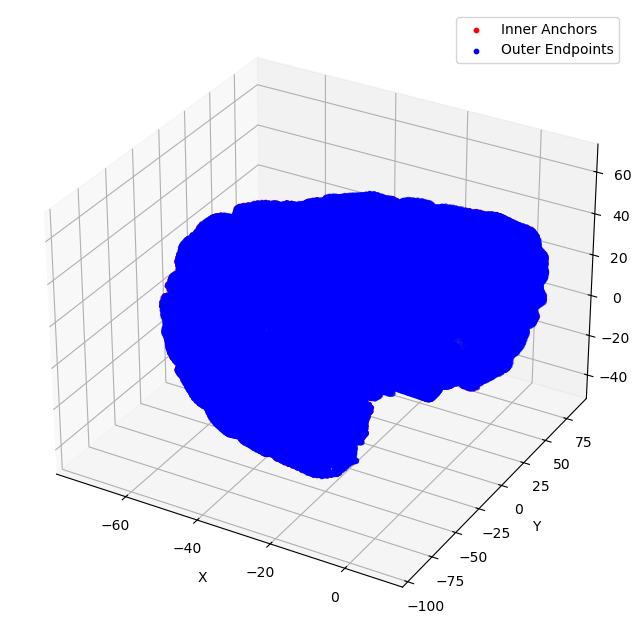

In [11]:
import os
import numpy as np
import nibabel.freesurfer.io as fsio
import matplotlib.pyplot as plt

# --- INPUT FILES ---
subjects_dir = "/Users/teahserani/Desktop/Gyri_sulci/FreeSurferOutputs"
subject_id = "388_21yrOld_edited"
hemi = "lh"  # or "rh"

curv_file = os.path.join(subjects_dir, subject_id, "surf", f"{hemi}.curv")
sulc_file = os.path.join(subjects_dir, subject_id, "surf", f"{hemi}.sulc")
surf_file = os.path.join(subjects_dir, subject_id, "surf", f"{hemi}.pial")  # or inflated

# --- LOAD DATA ---
curv = fsio.read_morph_data(curv_file)  # Curvature values
depth = fsio.read_morph_data(sulc_file)  # Using sulcus values as depth

coords, faces = fsio.read_geometry(surf_file)  # Coordinates and faces
nvertices = coords.shape[0]

# --- SIMULATE FOLD LABELS ---
# Assume negative sulcus values indicate folds (sulcal regions)
folds = -1 * np.ones(nvertices, dtype=int)
folds[depth < 0] = 1  # Label all sulcal regions as fold 1

# --- FIND DEEPEST POINTS (Inner Anchors) ---
# Inner anchors are vertices with high curvature * depth values in the fold region
curvature_depth = curv * depth
threshold = np.median(curvature_depth) + 2 * np.std(curvature_depth)  # Simple thresholding for depth

inner_anchors = np.where(curvature_depth > threshold)[0]  # Indices of inner anchor points (deepest points)

# --- FIND OUTER ENDPOINTS ---
# Simple method: find boundary vertices (those on the mesh boundary with high depth)
boundary_mask = np.zeros(nvertices, dtype=bool)
boundary_mask[depth < -0.1] = True  # Rough threshold to consider boundary (e.g., high negative depth)

outer_endpoints = np.where(boundary_mask)[0]  # Indices of outer boundary endpoints

# --- SIMULATE FUNDUS CURVE (CONNECTING INNER TO OUTER POINTS) ---
# This step is simplified. We'll assume the connection between anchors is just the shortest path
# In reality, you might want to use a more sophisticated method like graph-based pathfinding.

def connect_points(inner_anchors, outer_endpoints, coords):
    # Simple direct connection (this is just an example)
    # In real applications, you'd use pathfinding algorithms to connect these points.
    connections = []
    for inner in inner_anchors:
        closest_outer = min(outer_endpoints, key=lambda x: np.linalg.norm(coords[inner] - coords[x]))
        connections.append((inner, closest_outer))
    return connections

connections = connect_points(inner_anchors, outer_endpoints, coords)

# --- VISUALIZE RESULTS ---
# Plot the points and connections for a simple visualization
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='gray', s=1)  # All vertices

# Plot the inner anchors (deepest points)
ax.scatter(coords[inner_anchors, 0], coords[inner_anchors, 1], coords[inner_anchors, 2], c='red', s=10, label="Inner Anchors")

# Plot the outer endpoints (boundary points)
ax.scatter(coords[outer_endpoints, 0], coords[outer_endpoints, 1], coords[outer_endpoints, 2], c='blue', s=10, label="Outer Endpoints")

# Plot connections (fundus curves)
for conn in connections:
    ax.plot([coords[conn[0], 0], coords[conn[1], 0]], 
            [coords[conn[0], 1], coords[conn[1], 1]], 
            [coords[conn[0], 2], coords[conn[1], 2]], c='orange', linewidth=2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# --- OUTPUT FUNDUS CONNECTIONS ---
# You can save the connections or perform further analysis here
